| Nom de la colonne               | Type      | Description simplifiée                        |
| ------------------------------- | --------- | --------------------------------------------- |
| `ID`                            | object    | Identifiant unique du prêt                    |
| `customer_id`                   | int       | Identifiant du client                         |
| `country_id`                    | object    | Pays (ici uniquement "Kenya")                 |
| `tbl_loan_id`                   | int       | ID du prêt                                    |
| `lender_id`                     | int       | ID du prêteur                                 |
| `loan_type`                     | object    | Type de prêt (Type\_1 à Type\_22)             |
| `Total_Amount`                  | float     | Montant emprunté                              |
| `Total_Amount_to_Repay`         | float     | Montant à rembourser                          |
| `disbursement_date`, `due_date` | object    | Dates du prêt                                 |
| `duration`                      | int       | Durée du prêt en jours                        |
| `New_versus_Repeat`             | object    | "New Loan" ou "Repeat Loan"                   |
| `Amount_Funded_By_Lender`       | float     | Montant financé par le prêteur                |
| `Lender_portion_Funded`         | float     | Portion financée                              |
| `Lender_portion_to_be_repaid`   | float     | Ce que le prêteur doit récupérer              |
| `target`                        | int (0/1) | **Variable à prédire : défaut de paiement ?** |


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as mns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score

import shap
import tqdm
import joblib

## Collecte et premières observations

In [66]:
data = pd.read_csv("../Data/Train.csv")
df = data.copy()
df.sample(10)

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
23920,ID_257733289045267278,257733,Kenya,289045,267278,Type_1,980.0,980.0,2022-10-27,2022-11-03,7,Repeat Loan,294.00,0.300000,294.0,0
9545,ID_254526226791267278,254526,Kenya,226791,267278,Type_1,26790.0,26790.0,2022-07-28,2022-08-04,7,Repeat Loan,8037.00,0.300000,8037.0,0
46417,ID_253441239737267278,253441,Kenya,239737,267278,Type_1,2729.0,2729.0,2022-08-19,2022-08-26,7,Repeat Loan,0.00,0.000000,0.0,0
44647,ID_246758258605267278,246758,Kenya,258605,267278,Type_1,2319.0,2319.0,2022-09-13,2022-09-20,7,Repeat Loan,695.70,0.300000,696.0,0
28069,ID_244559276294267278,244559,Kenya,276294,267278,Type_1,3285.0,3404.0,2022-10-06,2022-10-13,7,Repeat Loan,985.50,0.300000,1021.0,0
21749,ID_102250252984267278,102250,Kenya,252984,267278,Type_1,18216.0,18326.0,2022-09-06,2022-09-13,7,Repeat Loan,35.35,0.001941,36.0,0
66325,ID_255528218750267278,255528,Kenya,218750,267278,Type_1,2330.0,2330.0,2022-07-18,2022-07-25,7,Repeat Loan,699.00,0.300000,699.0,0
34315,ID_248847250054267278,248847,Kenya,250054,267278,Type_1,4699.0,4800.0,2022-09-02,2022-09-09,7,Repeat Loan,1409.70,0.300000,1440.0,0
60855,ID_258861289605267278,258861,Kenya,289605,267278,Type_1,11453.0,11522.0,2022-10-28,2022-11-04,7,Repeat Loan,3435.90,0.300000,3457.0,0
62680,ID_259528222700267278,259528,Kenya,222700,267278,Type_1,20996.0,20996.0,2022-07-23,2022-07-30,7,Repeat Loan,6298.80,0.300000,6299.0,0


In [67]:
df.shape

(68654, 16)

In [68]:
df.columns

Index(['ID', 'customer_id', 'country_id', 'tbl_loan_id', 'lender_id',
       'loan_type', 'Total_Amount', 'Total_Amount_to_Repay',
       'disbursement_date', 'due_date', 'duration', 'New_versus_Repeat',
       'Amount_Funded_By_Lender', 'Lender_portion_Funded',
       'Lender_portion_to_be_repaid', 'target'],
      dtype='object')

In [69]:
df.describe()

,customer_id,tbl_loan_id,lender_id,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
count,68654.000000,68654.000000,68654.000000,6.865400e+04,6.865400e+04,68654.000000,6.865400e+04,68654.000000,6.865400e+04,68654.000000
mean,254390.256780,263056.266248,266420.528462,1.483683e+04,1.563993e+04,8.544586,2.545663e+03,0.218679,2.652621e+03,0.018324
std,26642.719918,39486.661487,3590.999004,1.416499e+05,1.650784e+05,13.343145,1.192272e+04,0.129832,1.338006e+04,0.134120
min,145.000000,101323.000000,245684.000000,2.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,248945.750000,233942.250000,267278.000000,2.295000e+03,2.329000e+03,7.000000,2.340000e+02,0.118712,2.390000e+02,0.000000
50%,255361.000000,260305.500000,267278.000000,5.249000e+03,5.325000e+03,7.000000,9.150000e+02,0.300000,9.340000e+02,0.000000
75%,262269.250000,286962.750000,267278.000000,1.145000e+04,1.165000e+04,7.000000,2.272650e+03,0.300000,2.317000e+03,0.000000
max,312737.000000,375320.000000,267278.000000,2.300000e+07,2.541500e+07,1096.000000,1.600000e+06,1.168119,1.821338e+06,1.000000


In [70]:
df.describe(include="object")

,ID,country_id,loan_type,disbursement_date,due_date,New_versus_Repeat
count,68654,68654,68654,68654,68654,68654
unique,68654,1,22,768,893,2
top,ID_249117268933267278,Kenya,Type_1,2022-07-16,2022-07-23,Repeat Loan
freq,1,68654,61723,938,940,68087


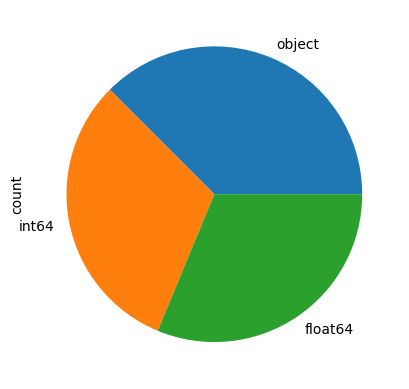

In [71]:
df.dtypes.value_counts().plot.pie()
plt.show()

In [72]:
df.dtypes

ID                              object
customer_id                      int64
country_id                      object
tbl_loan_id                      int64
lender_id                        int64
loan_type                       object
Total_Amount                   float64
Total_Amount_to_Repay          float64
disbursement_date               object
due_date                        object
duration                         int64
New_versus_Repeat               object
Amount_Funded_By_Lender        float64
Lender_portion_Funded          float64
Lender_portion_to_be_repaid    float64
target                           int64
dtype: object

## Analyse de forme

### Missing data

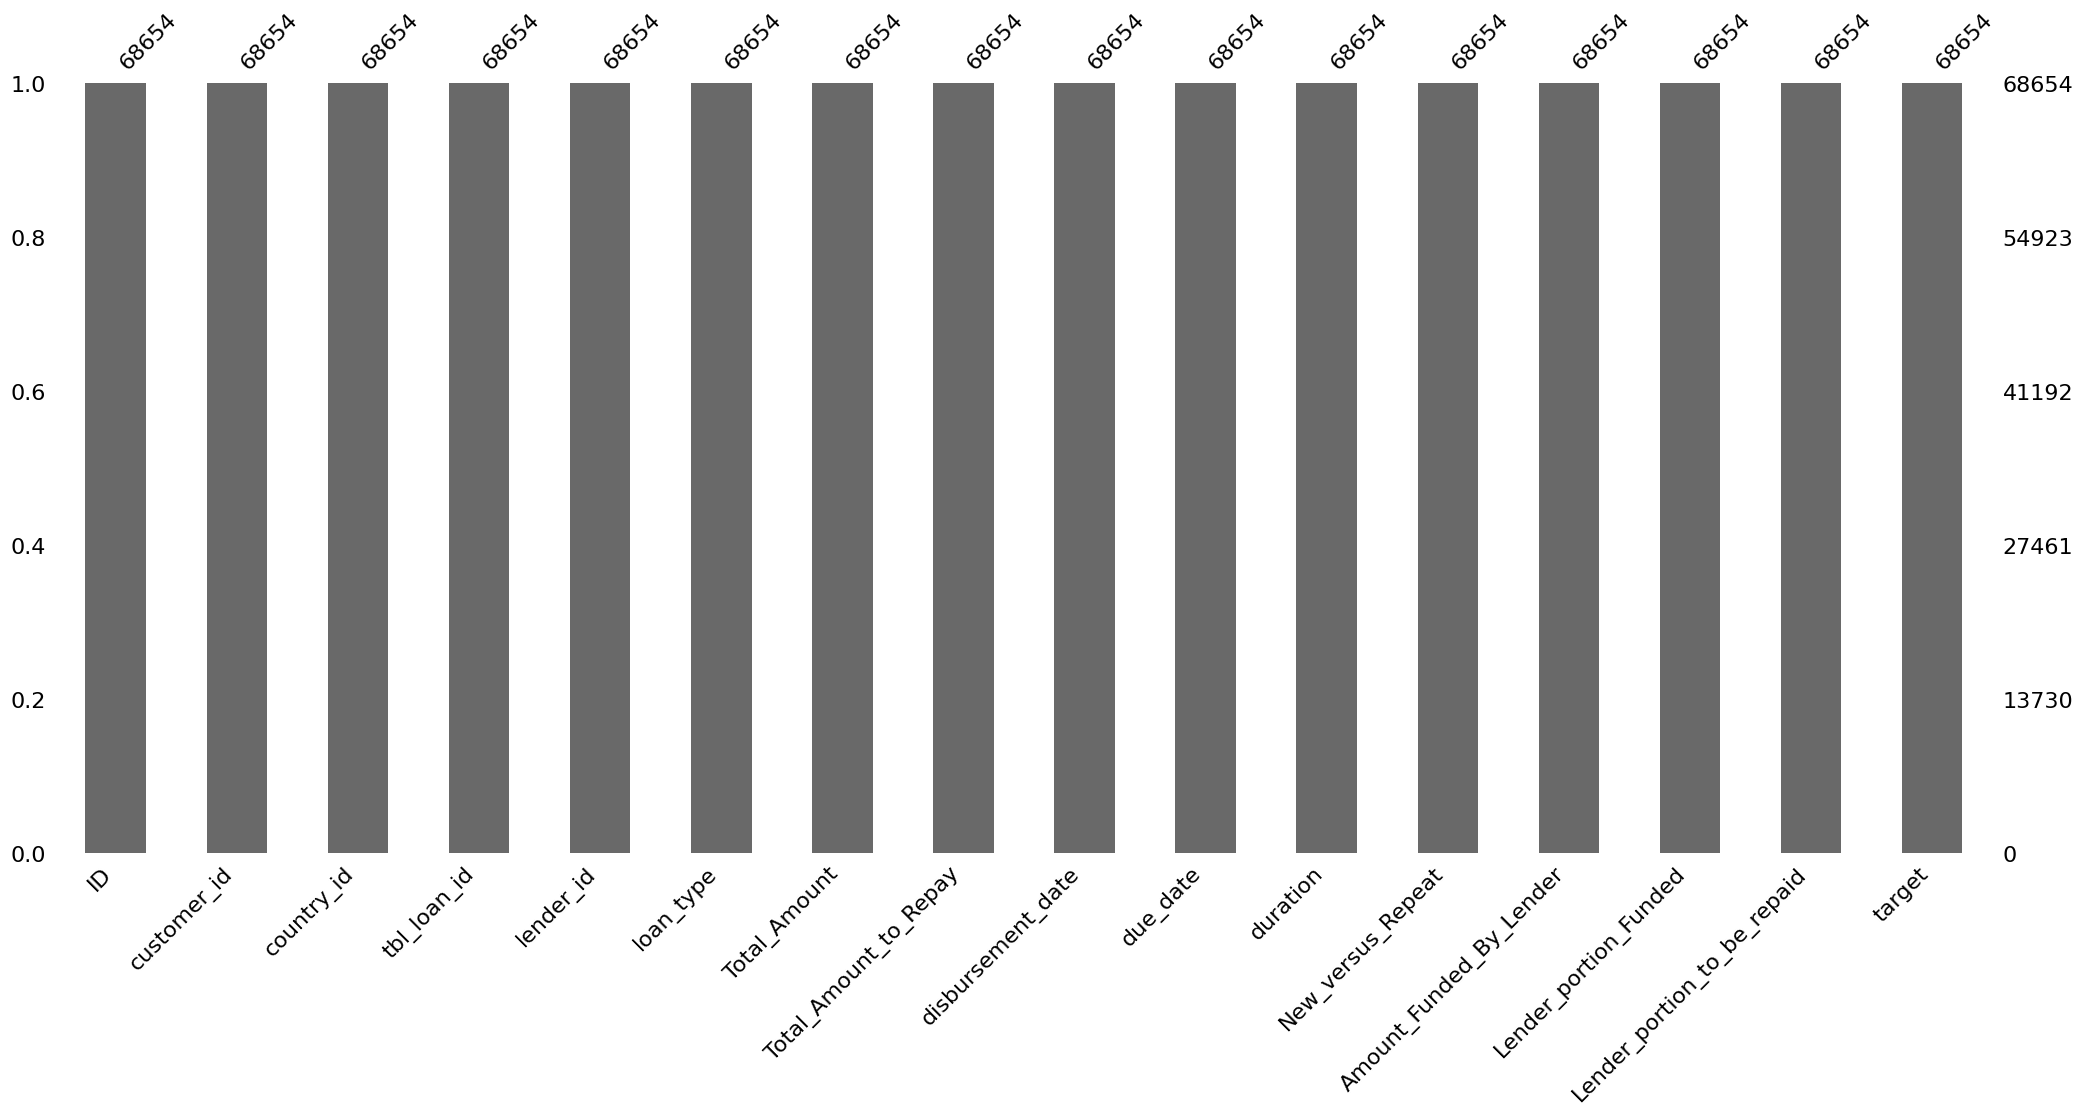

In [9]:
mns.bar(df)
plt.show()

**Pas de valeurs manquantes.**

### S'assurer que les colonnes de date sont en format datetime

In [10]:
df['disbursement_date'] = pd.to_datetime(df['disbursement_date'], errors='coerce')
df['due_date'] = pd.to_datetime(df['due_date'], errors='coerce')

### Créer des variables dérivées

Pour mieux capturer les caractéristiques temporelles

In [11]:
df['disbursement_month'] = df['disbursement_date'].dt.month
df['disbursement_dayofweek'] = df['disbursement_date'].dt.dayofweek

S'assurer que la variable duration est fiable : 

In [12]:
((df['due_date'] - df['disbursement_date']).dt.days - df['duration']).describe()

count    68654.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

L'écart est nul donc pas besoin de dériver une nouvelle variable. 

On peut garder duration

Capturons la charge relative au prêt, le taux d'effort

In [13]:
df['repayment_ratio'] = df['Total_Amount_to_Repay'].divide(df['Total_Amount'])

### Encoder les colonnes catégorielles

In [14]:
Hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
Hot_encoder.fit(df[['New_versus_Repeat']])
encoded_var= pd.DataFrame(Hot_encoder.transform(df[['New_versus_Repeat']]).toarray(), columns=Hot_encoder.get_feature_names_out(['New_versus_Repeat']))
df = pd.concat([df, encoded_var], axis=1)

df['loan_type_encoded'] = df['loan_type'].astype('category').cat.codes

pd.set_option('display.max_columns', 25)
df.sample(5)

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,disbursement_month,disbursement_dayofweek,repayment_ratio,New_versus_Repeat_Repeat Loan,loan_type_encoded
38617,ID_250225266431267278,250225,Kenya,266431,267278,Type_1,25050.0,25353.0,2022-09-24,2022-10-01,7,Repeat Loan,6.54,0.000261,7.0,0,9,5,1.012096,1.0,0
21527,ID_238243360121267278,238243,Kenya,360121,267278,Type_4,100000.0,115000.0,2023-10-05,2024-01-03,90,Repeat Loan,33333.00,0.333330,38333.0,0,10,3,1.150000,1.0,17
50249,ID_264724305336267278,264724,Kenya,305336,267278,Type_1,24490.0,24826.0,2022-11-28,2022-12-05,7,Repeat Loan,7347.00,0.300000,7448.0,0,11,0,1.013720,1.0,0
64849,ID_264472295826267278,264472,Kenya,295826,267278,Type_1,12997.0,13162.0,2022-11-08,2022-11-15,7,Repeat Loan,1447.67,0.111385,1466.0,0,11,1,1.012695,1.0,0
20526,ID_249318237284267278,249318,Kenya,237284,267278,Type_1,450.0,455.0,2022-08-15,2022-08-22,7,Repeat Loan,135.00,0.300000,137.0,0,8,0,1.011111,1.0,0


### Supprimer les colonnes desormais inutiles

In [15]:
cols_to_drop = [
    'ID', 'customer_id', 'lender_id', 'tbl_loan_id', 'disbursement_date', 'due_date',
    'loan_type', 'New_versus_Repeat', 'country_id'
]
df.drop(columns=cols_to_drop, inplace=True)
print(df.shape)
df.dtypes

(68654, 12)


Total_Amount                     float64
Total_Amount_to_Repay            float64
duration                           int64
Amount_Funded_By_Lender          float64
Lender_portion_Funded            float64
Lender_portion_to_be_repaid      float64
target                             int64
disbursement_month                 int32
disbursement_dayofweek             int32
repayment_ratio                  float64
New_versus_Repeat_Repeat Loan    float64
loan_type_encoded                   int8
dtype: object

## Analyse de fond

### Séparation des featrues de la cible

In [16]:
X = df.drop(columns='target')
y = df[['target']]

### Distribution de la cible

In [17]:
y.value_counts(normalize=True) * 100

target
0         98.167623
1          1.832377
Name: proportion, dtype: float64

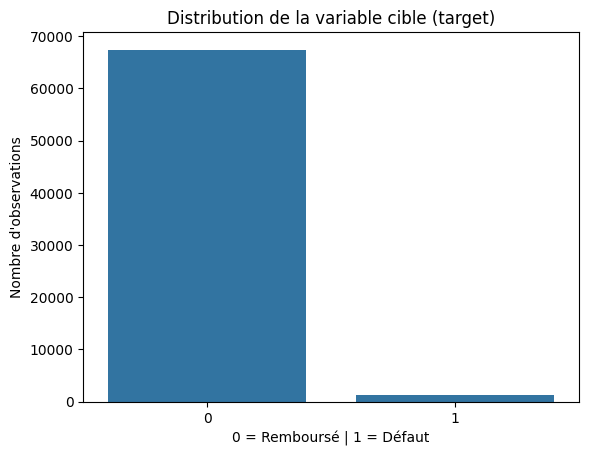

In [18]:
sns.countplot(y, x='target')
plt.title("Distribution de la variable cible (target)")
plt.xlabel("0 = Remboursé | 1 = Défaut")
plt.ylabel("Nombre d'observations")
plt.show()

**Cible très désiquilibrée. On aura peut-être besoin d'une augmentation smote**

### Analyse des features

#### Distribution de certaines features

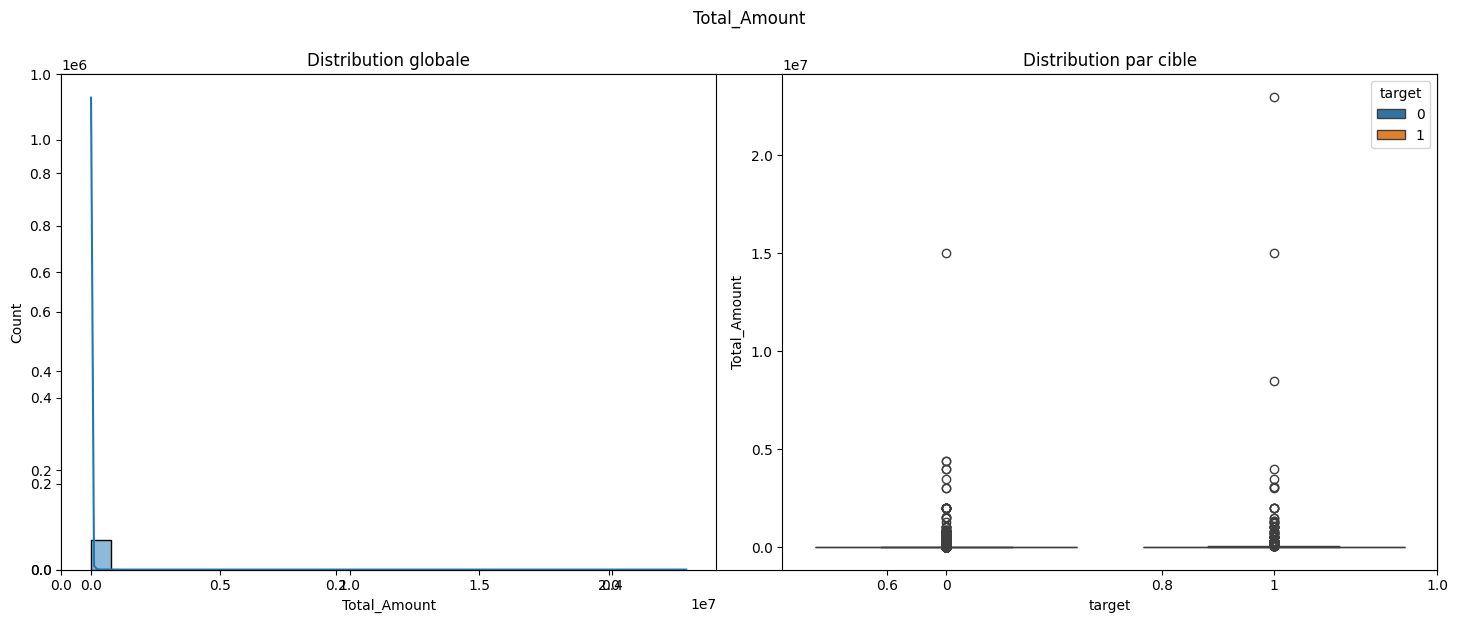

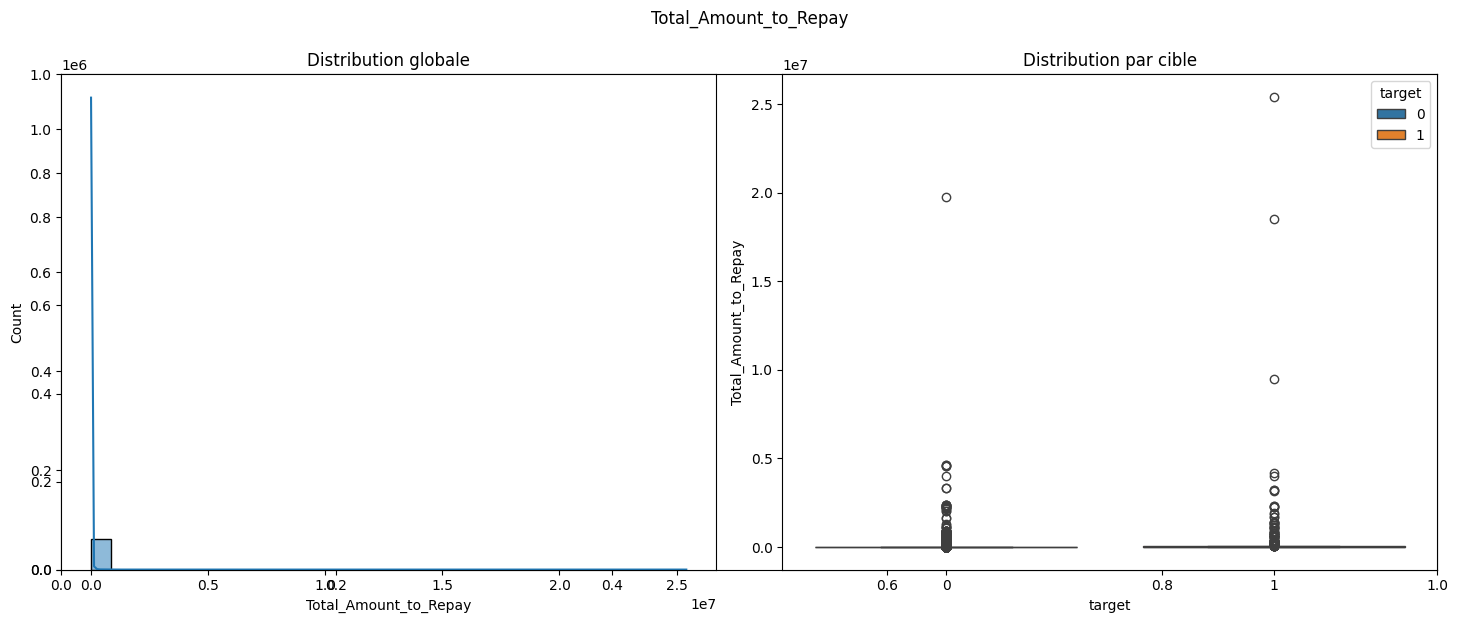

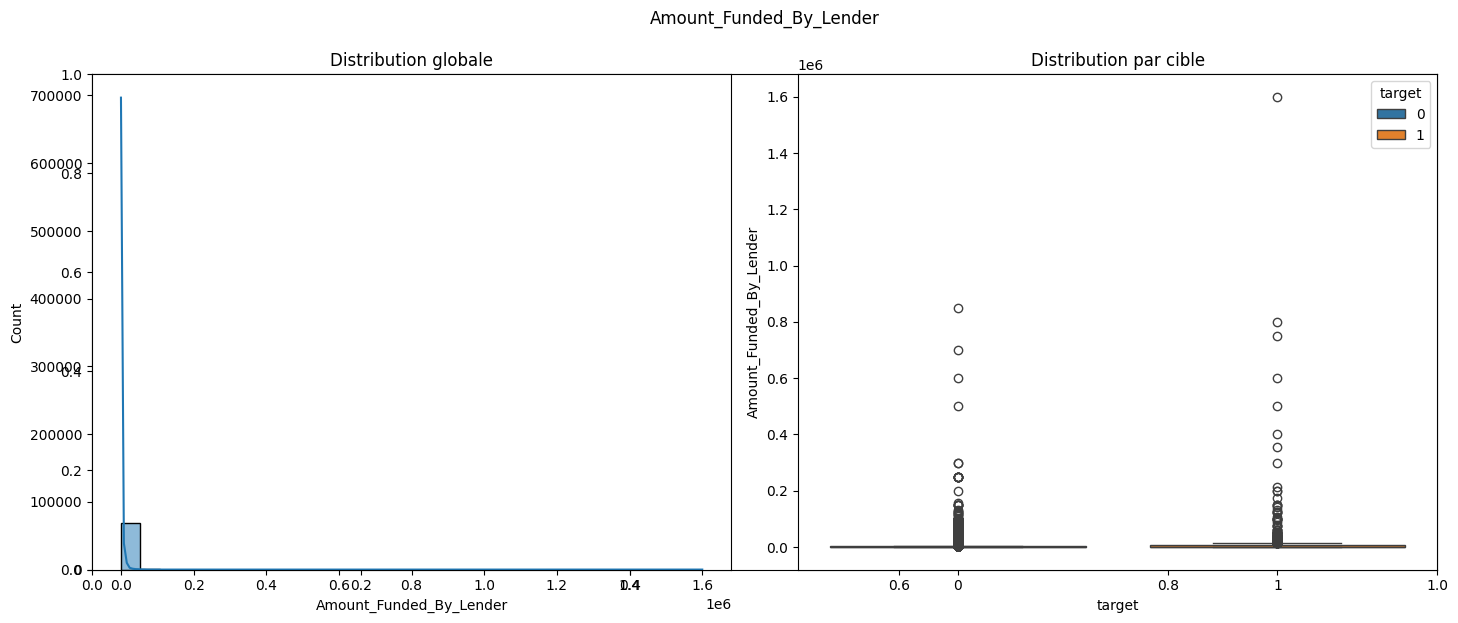

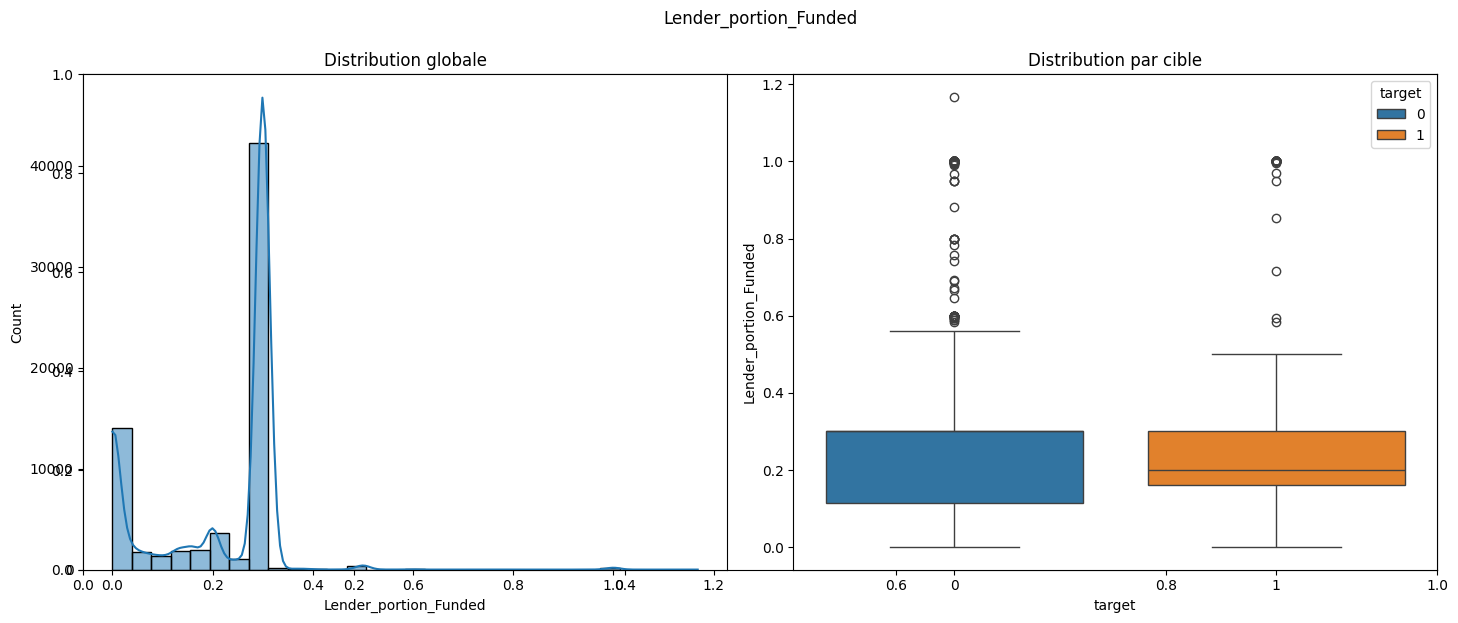

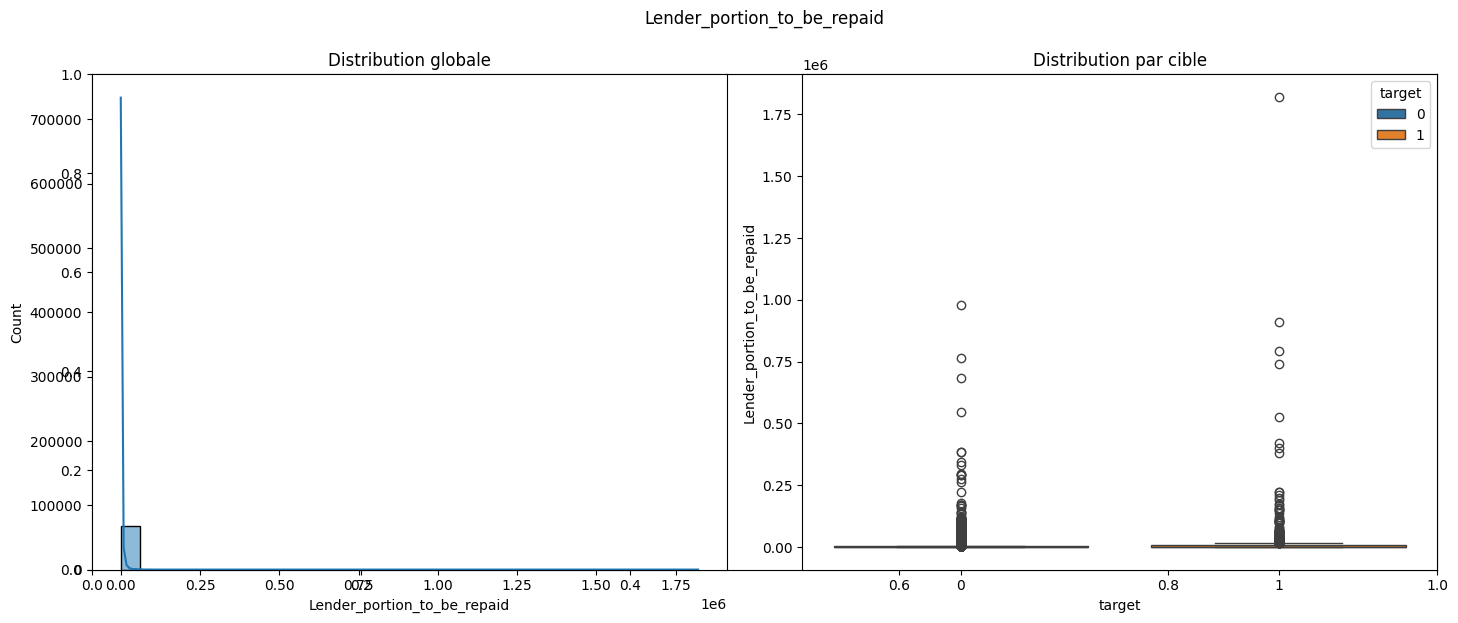

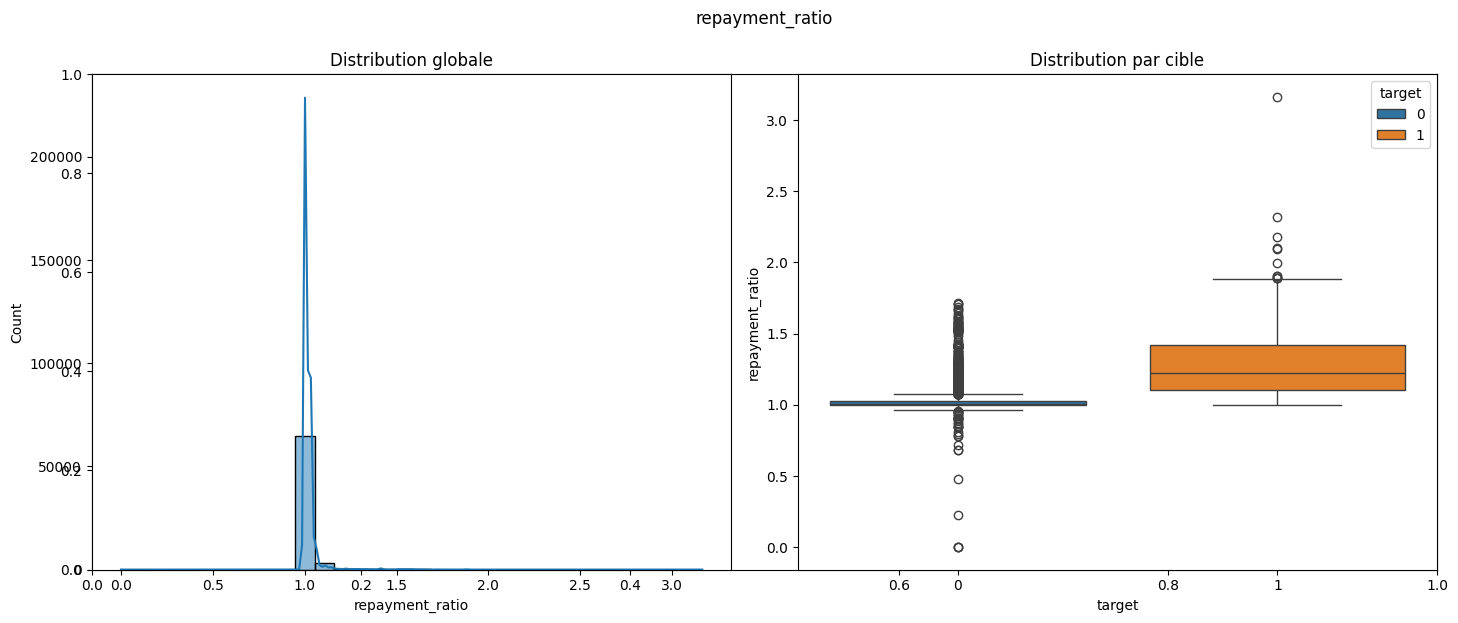

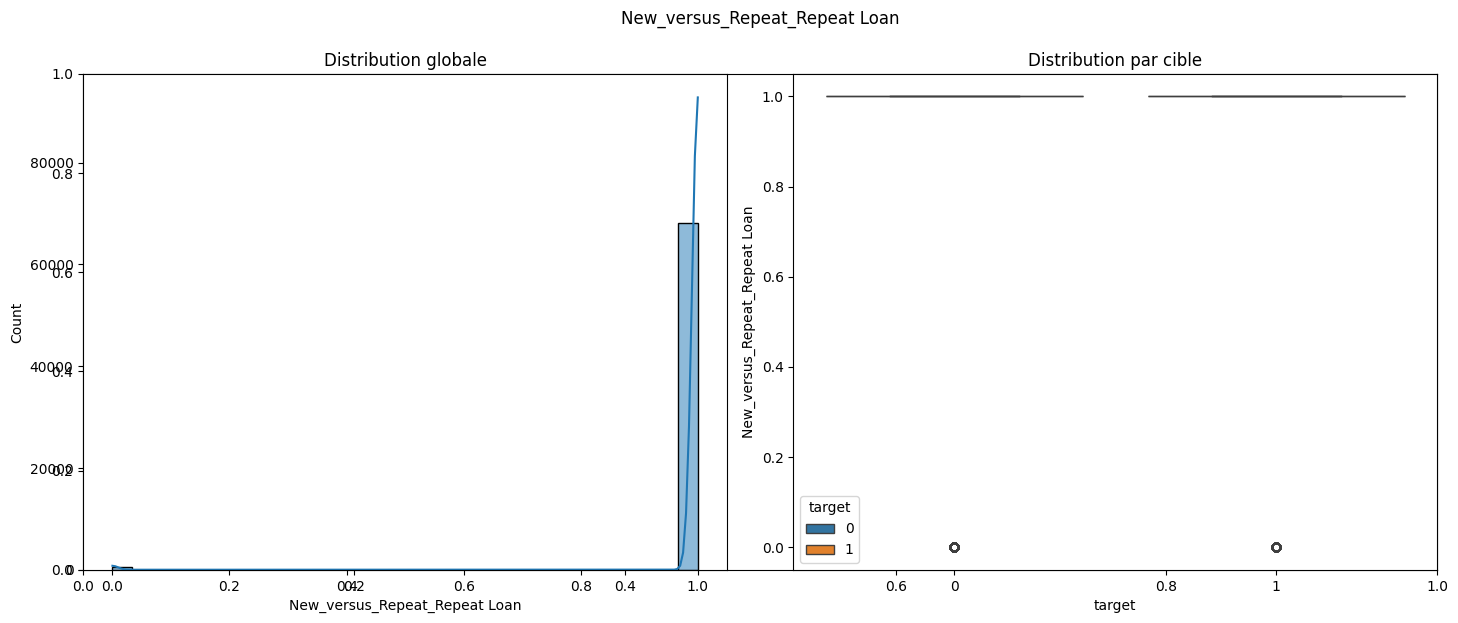

In [19]:
for col in X.select_dtypes(include=['float64']).columns:
    plt.figure(figsize=(15, 7))
    plt.title(f'{col}\n\n', loc='center')

    # Histogramme global
    plt.subplot(1, 2, 1)
    sns.histplot(X[col], kde=True, bins=30)
    plt.title(f'Distribution globale')
    
    # Histogramme par classe (target = 0 ou 1)
    plt.subplot(1, 2, 2)
    #sns.histplot(data=X.assign(target=y), x=col, hue='target', kde=True, bins=30, multiple='stack')
    sns.boxplot(data=X.assign(target=y), x='target', y=col, hue='target')
    plt.title(f'\nDistribution par cible')

    plt.tight_layout()
    plt.show()

* **Les features '*Total_Amount*','*Total_Amount_to_Repay*' et '*Amount_Funded_By_Lender*' suivent pratiquement la même distribution et ne dégagent pas de tendances particulières.**
    * **Par contre, elles présentent beaucoup d'outliers.<br> Nous continuerons avec elles comme cela pour le moment.**
* **'*Lender_portion_Funded*' et *'Lender_portion_to_be_repaid'* aussi présentent d'importants outliers et montre visuellement pas de tendances dans les données.<br> Nous les gardons aussi telles quelles pour le moment.**

* **`Par contre avec *'repayment_ratio'* nous voyons que les prêts à défaut ont des valeurs élevées.`** 

#### Observation des proportions de défaut par features entiers

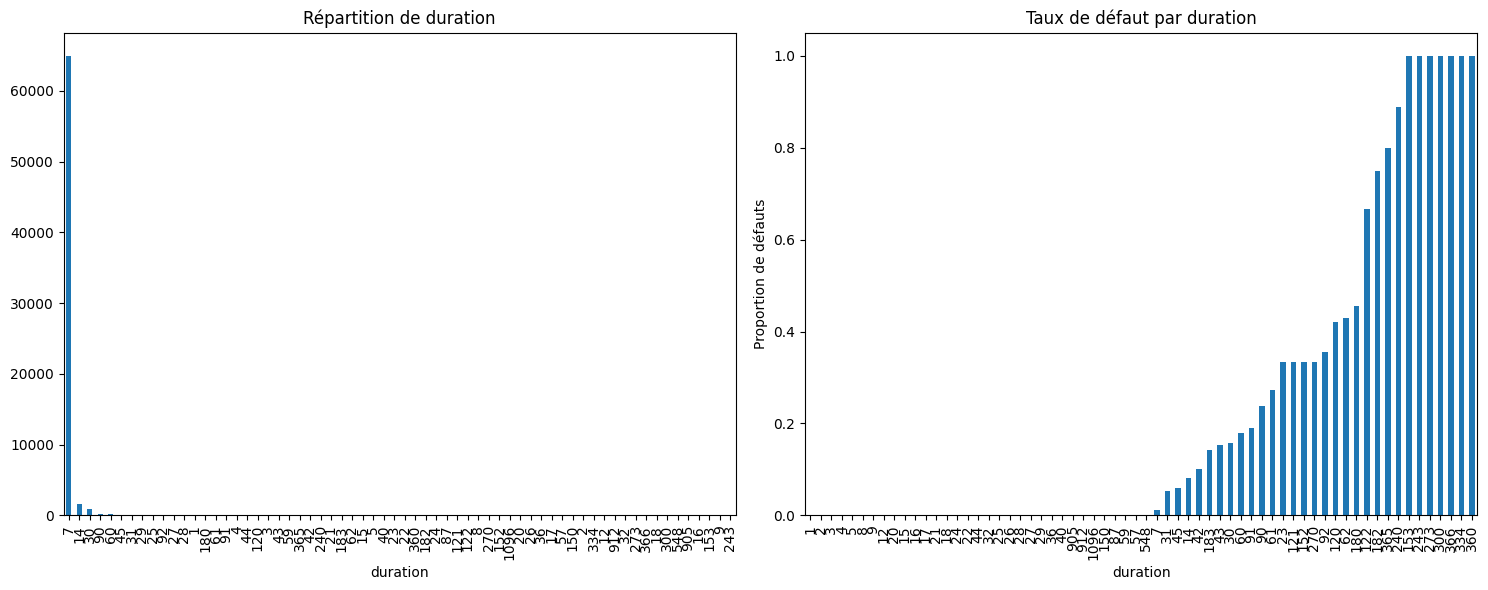

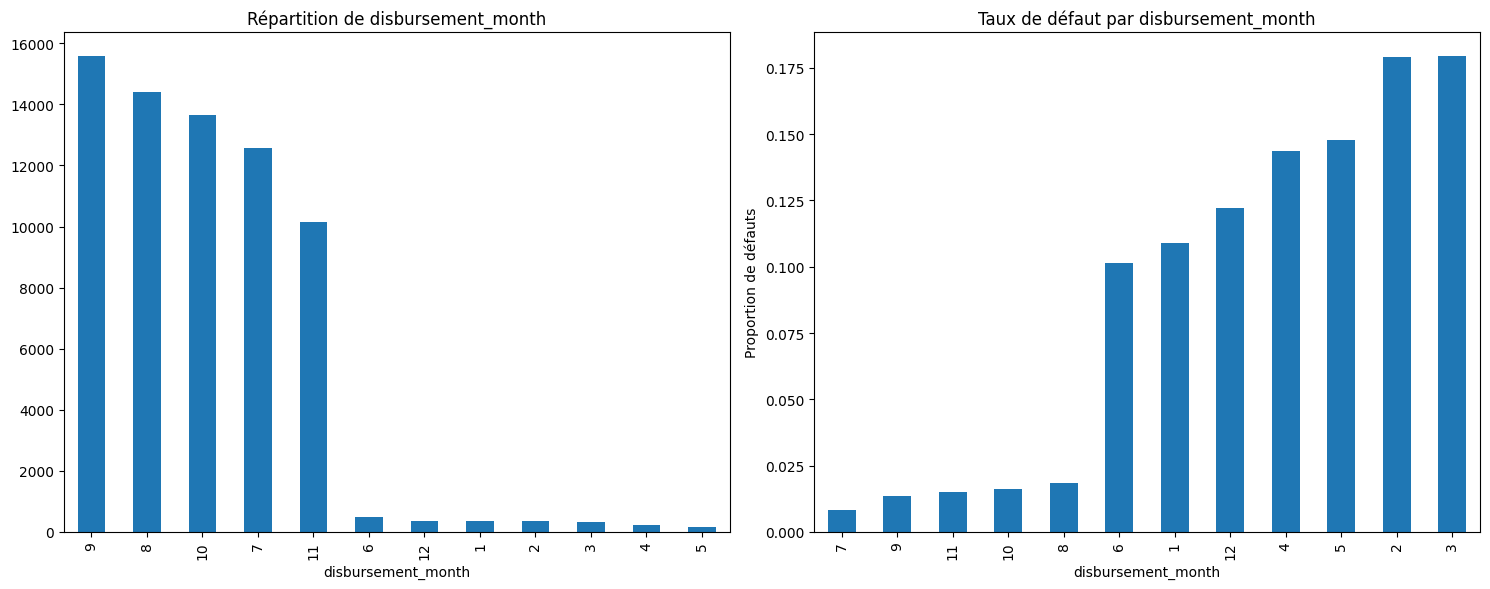

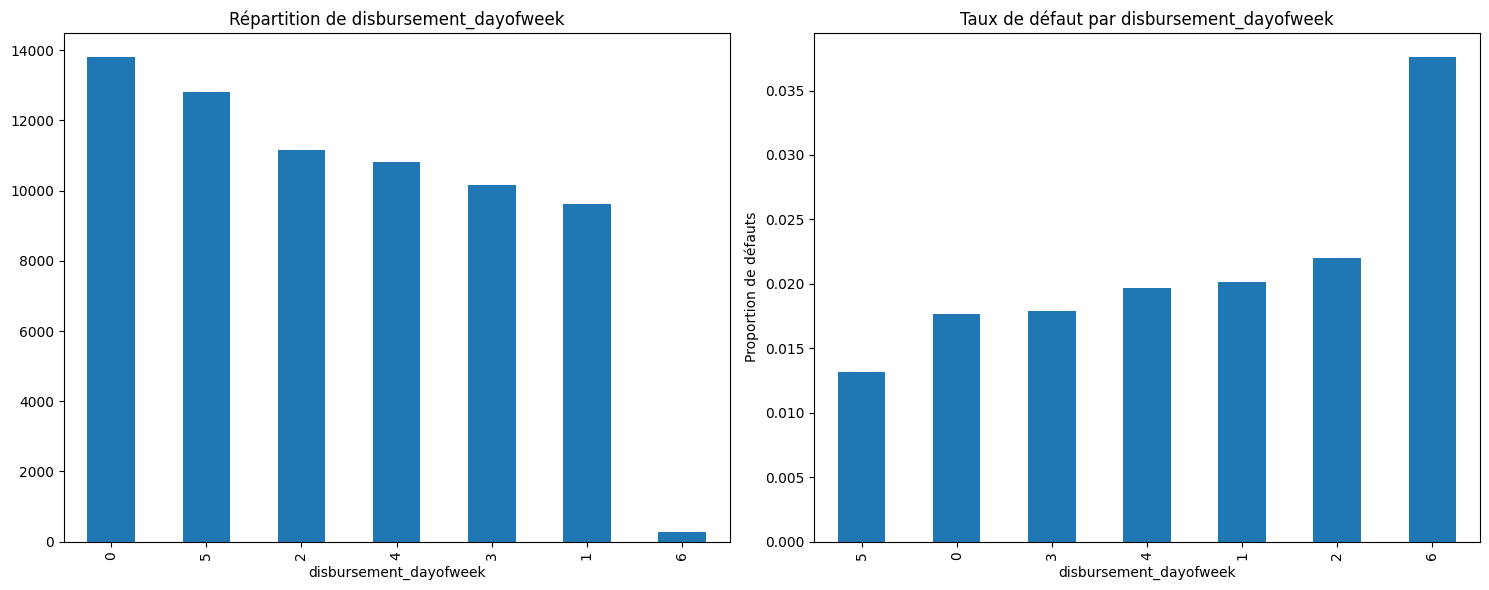

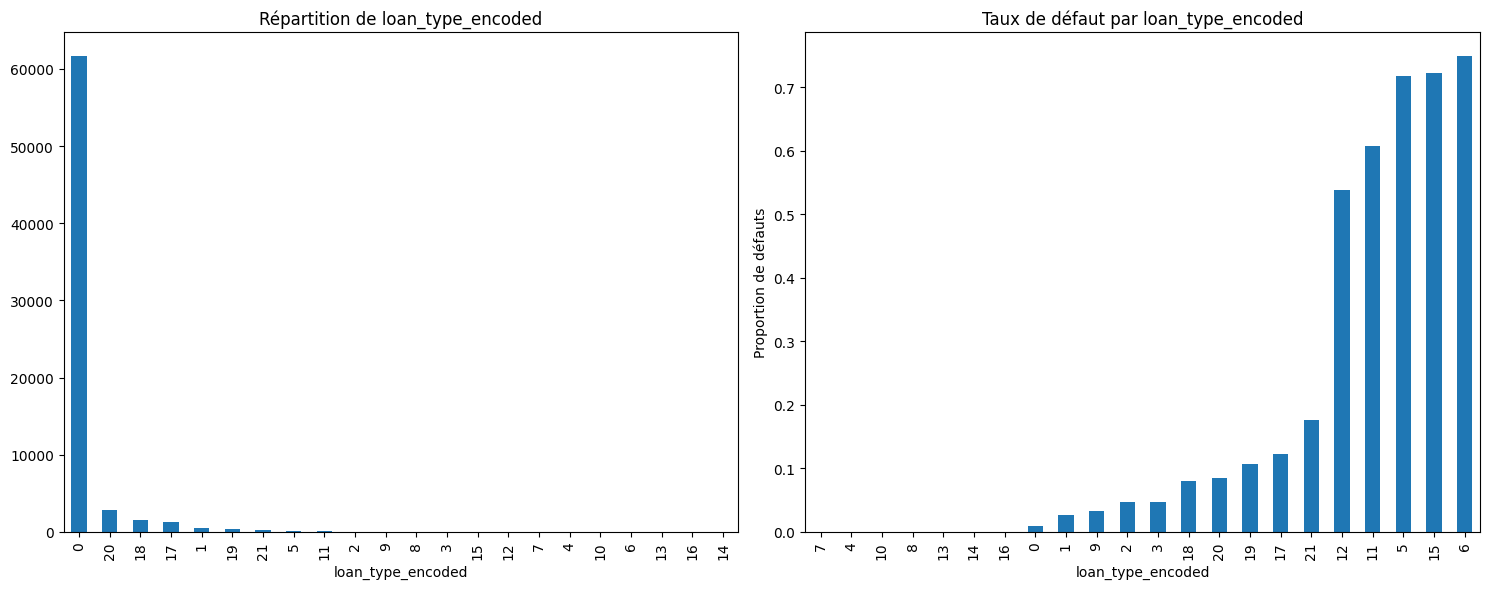

In [20]:
for feature in X.select_dtypes(include=['int8', 'int16', 'int32', 'int64']).columns:
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    X[feature].value_counts().plot(kind='bar')
    plt.title(f"Répartition de {feature}")

    plt.subplot(1, 2, 2)
    X.join(y).groupby(feature)['target'].mean().sort_values().plot(kind='bar')
    plt.title(f"Taux de défaut par {feature}")
    plt.ylabel("Proportion de défauts")

    plt.tight_layout()
    plt.show()

* **Les prêts ont presque tous une 'duration' de 7.**
    * Cette 'duration' est aussi les plus remboursé avec un taux de défaut d'environ $10^{-2}$%

* **Les prêts sont plus souvent débourser du mois de Juillet à Novembre.**
    * *Et les prêts de cette période connaissent moins de défaut de payement que durant le reste de l'année.*

* **Les prêts sont débourser presque autant tous les jours de la semaine avec une hausse les lundi et samedi (*premier et dernier jour ouvrables*) sauf le dimanche qui n'en connait pratiquement pas (*le dimanche est généralement férié*).**
    * *Et tous les jours connaissent presque autant de défauts de payement sauf le dimanche dont environ 3.5% des prêts déboursés connaissent un défaut de payement. <br>Les déboursement de lundi et de samedi connaisse moins de défaut.*

* **Les prêts sont presque tous de type 'Type_0' et ce type de prêts est três souvnet remboursé normalement. Contrairement aux types 'Type12', 'Type11', 'Type5', 'Type15', 'Type6' <br> Les types 'Type20', 'Type18', 'Type17' sont aussi sollicité mais très peu et connaissent un taux de défaut pas très élevé (environ 15%)**

**`Nous verons si cela nous servira dans la suite !`**

### Corrélations entre features

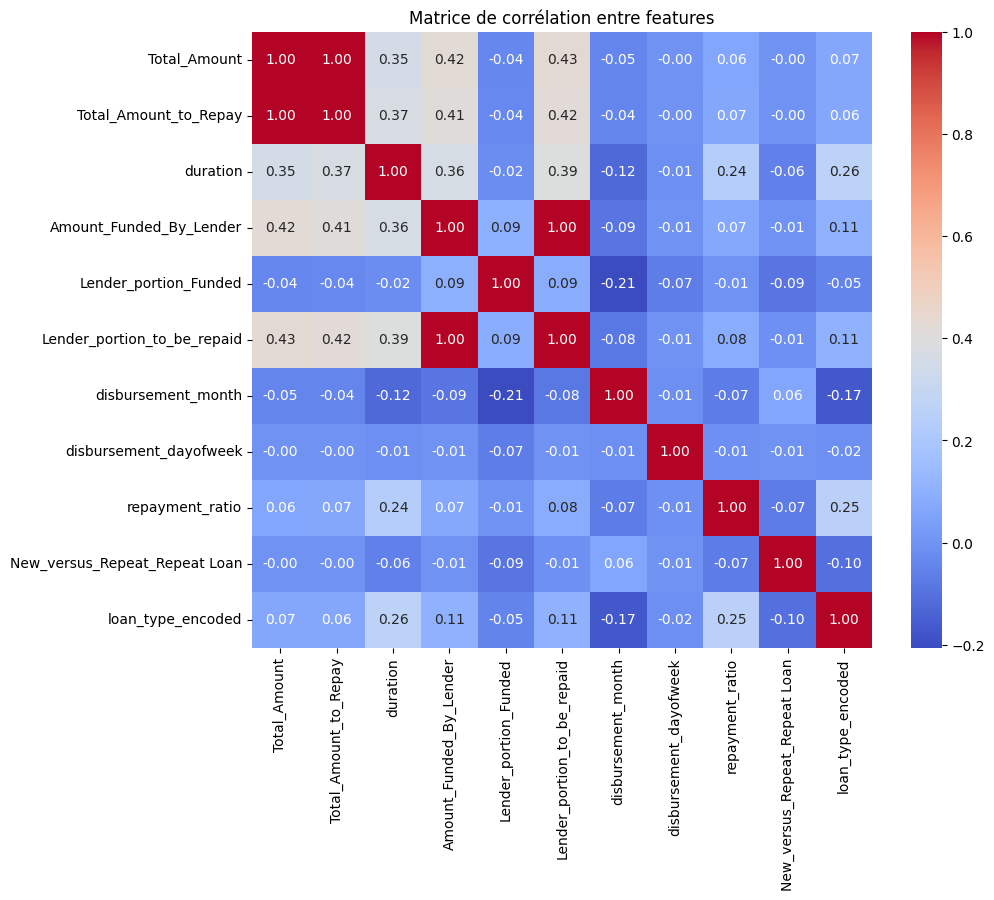

In [21]:
corr_matrix = X.join(y).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.drop('target', axis=0).drop('target', axis=1), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation entre features")
plt.show()

**Nous remarquons que les features '*Total_Amount_to_Repay*' et '*Total_Amount*' nous donne exactement la même information, à la même échelle.**

**Pareil pour *'Lender_portion_to_be_repaid'* et *'Amount_Funded_By_Lender'***

**`Nous éliminerons en une dans chaque paire dans la suite.`**

### Corrélations entre features et target

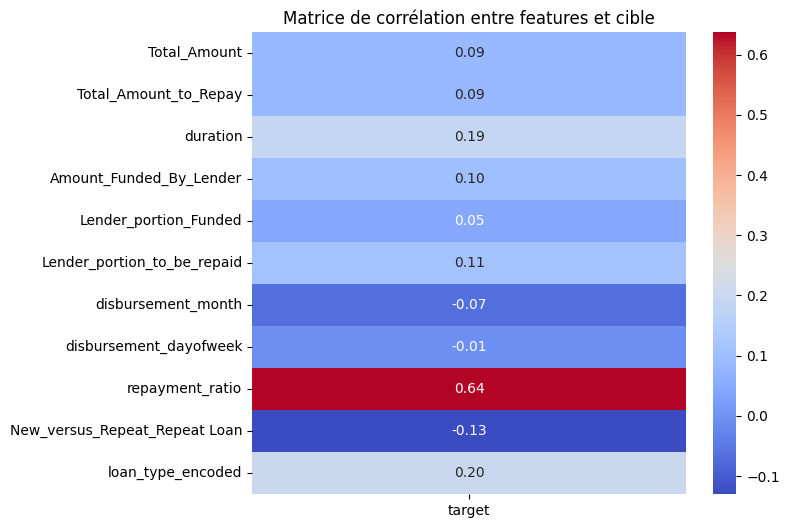

In [22]:
plt.figure(figsize=(7, 6))
plt.title("Matrice de corrélation entre features et cible")
sns.heatmap(corr_matrix[['target']].drop('target', axis=0), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

***Supprimons déja les features qui sont corrélées à moins de 0.1 (en arrondi) avec la cible.***

In [23]:
X_new = (X.copy()).drop([col for col in X.columns if abs(round(corr_matrix[['target']].loc[col].item(), 1)) < 0.1], axis=1)
X_new.columns.to_list()

['Total_Amount',
 'Total_Amount_to_Repay',
 'duration',
 'Amount_Funded_By_Lender',
 'Lender_portion_to_be_repaid',
 'disbursement_month',
 'repayment_ratio',
 'New_versus_Repeat_Repeat Loan',
 'loan_type_encoded']

### Analyse multivariée

#### Pairplots

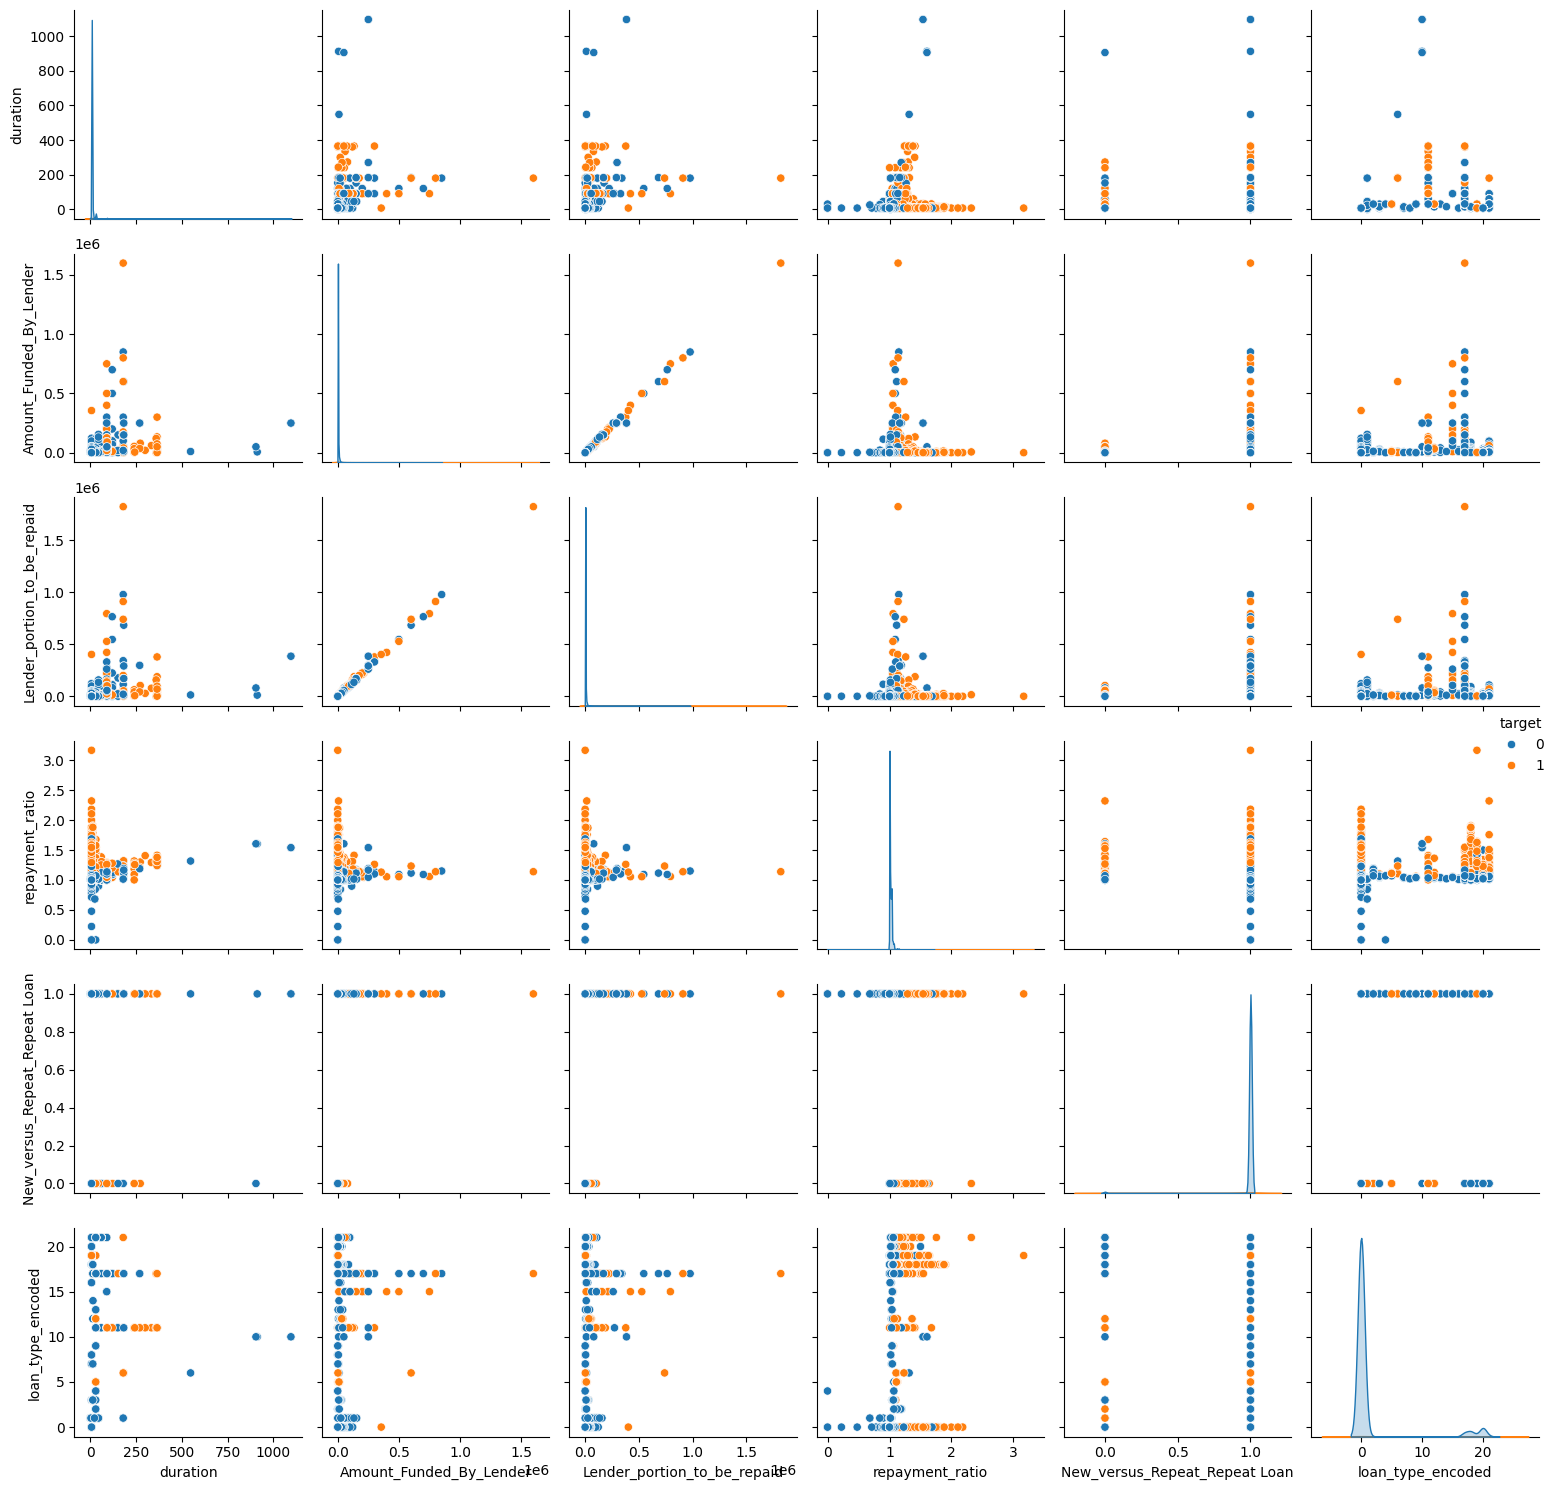

In [24]:
# Pairplot avec queues features
sns.pairplot(X.drop([
                        col for col in X.columns if abs(
                            corr_matrix[['target']].loc[col].item()) < 0.1],
                            axis=1).assign(target=y),
                            hue="target",
                            diag_kind="kde")
plt.tight_layout()
plt.show()

* **Déja, nous voyons que 'repayment_ratio' a une séparation nette entre classes.**
    * Feature clairement la plus importante et donc informative.

* **Quasi colinéarité entre 'Amount_Funded_By_Lunder' et 'Lender_portion_to_be_repaid'**
    * Nous pouvons en éliminer un sans vraiment perdre d'informations.

* **Pas de séparation (très peu d'information) pour 'New_versus_Repeat_encoded', 'loan_type_encoded', 'disbursement_month'**

### Sélection des features d'entrainement

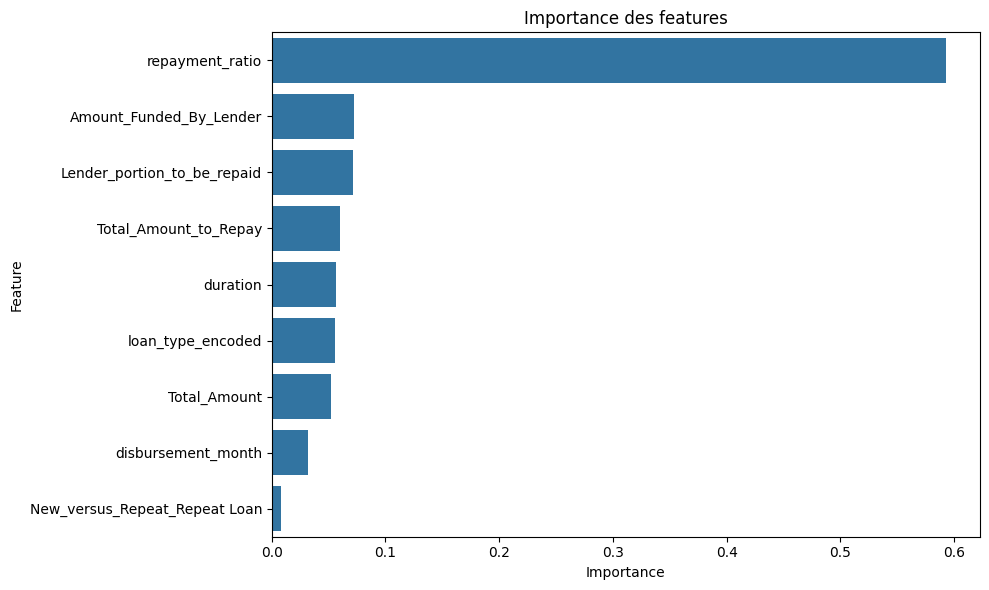

In [25]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_new, y.values.ravel())
importances = model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_new.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Importance des features")
plt.tight_layout()
plt.show()

**Au vue de toutes les analyses précédentes et des résultats de ce test d'importance de features, <br>**
    ***`nous continuerons sans les features 'Total_Amount', 'disbursement_month' et 'New_versus_Repeat_encoded'.`***

In [26]:
features_selected = feature_importances[feature_importances['Importance'] > 0.055]['Feature'].tolist()
X_selected = X_new[features_selected]
X_selected.columns.to_list()

['repayment_ratio',
 'Amount_Funded_By_Lender',
 'Lender_portion_to_be_repaid',
 'Total_Amount_to_Repay',
 'duration',
 'loan_type_encoded']

## Préparation des données pour l'entrainement

### Normalisation

In [73]:
# Pour une regression logistic par exemple
scaler = StandardScaler()
scaler.fit(X_selected)
X_scaled = pd.DataFrame(scaler.transform(X_selected), columns=X_selected.columns)

### Spliting

In [74]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Pour les modèles qui nécessitent des données normalisées
X_train_scaled, X_test_scaled, _, _ = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

### Gestion du deséquilibre de la cible

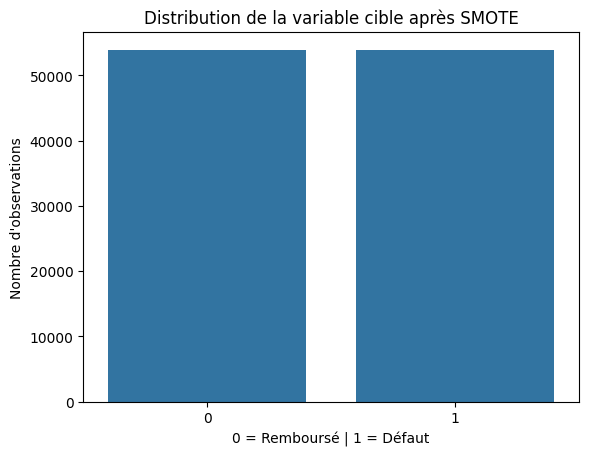

In [75]:
smote1, smote2 = SMOTE(random_state=42), SMOTE(random_state=42)
X_train_res, y_train_res = smote1.fit_resample(X_train, y_train)
X_train_scaled_res, _ = smote2.fit_resample(X_train_scaled, y_train)

sns.countplot(y_train_res, x='target')
plt.title("Distribution de la variable cible après SMOTE")
plt.xlabel("0 = Remboursé | 1 = Défaut")
plt.ylabel("Nombre d'observations")
plt.show()

## Modèles, entrainement et évaluation

Nous choisissons de comparer RandomForest, LinearRegression et XGBoost

| Modèle                 | Avantages                                                | Inconvénients                                | Normalisation ? |
| ---------------------- | -------------------------------------------------------- | -------------------------------------------- | --------------- |
| **LogisticRegression** | Simple, rapide, interprétable                            | Pas performant si relations non-linéaires    | ✅ Obligatoire   |
| **RandomForest**       | Gère non-linéarités, robustesse, importance des features | Moins bon sur petits jeux très déséquilibrés | ❌ Inutile       |
| **XGBoost**            | Très performant, gère bien les classes déséquilibrées    | Moins interprétable, plus lent               | ❌ Inutile       |


### Models

In [76]:
models = {
    'RandomForest' : RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression' : LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost' : XGBClassifier(eval_metric='logloss', random_state=42)
}

### Entrainement et évaluation

In [77]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    return (classification_report(y_test, y_pred),
            confusion_matrix(y_test, y_pred),
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred),
            roc_curve(y_test, y_pred_proba)
        )

In [78]:
reports = {}
confusion_mat = {}
metrics = {'RandomForest': {}, 'LogisticRegression': {}, 'XGBoost': {}}

#Entrainement sur les données rééquilibrées
for name, model in models.items():
    if name == 'LogisticRegression':
        reports[name], confusion_mat[name], metrics[name]['Accurancy'], metrics[name]['Precision'], metrics[name]['RecallScore'], metrics[name]['F1Score'], metrics[name]['RocCurve'] = train_and_evaluate(model, X_train_scaled_res, y_train_res, X_test_scaled, y_test)
    else:
        reports[name], confusion_mat[name], metrics[name]['Accurancy'], metrics[name]['Precision'], metrics[name]['RecallScore'], metrics[name]['F1Score'], metrics[name]['RocCurve'] = train_and_evaluate(model, X_train_res, y_train_res, X_test, y_test)
    
    print(f"\tModel: {name}")
    print(f"Accuracy: {metrics[name]['Accurancy']:.5f}")
    print(f"Precision: {metrics[name]['Precision']:.5f}")
    print(f"Recall: {metrics[name]['RecallScore']:.5f}")
    print(f"F1 Score: {metrics[name]['F1Score']:.5f}\n")

	Model: RandomForest
Accuracy: 0.99323
Precision: 0.75563
Recall: 0.93254
F1 Score: 0.83481

	Model: LogisticRegression
Accuracy: 0.94960
Precision: 0.26139
Recall: 0.95635
F1 Score: 0.41056

	Model: XGBoost
Accuracy: 0.99148
Precision: 0.70769
Recall: 0.91270
F1 Score: 0.79723



#### Confusion matrix

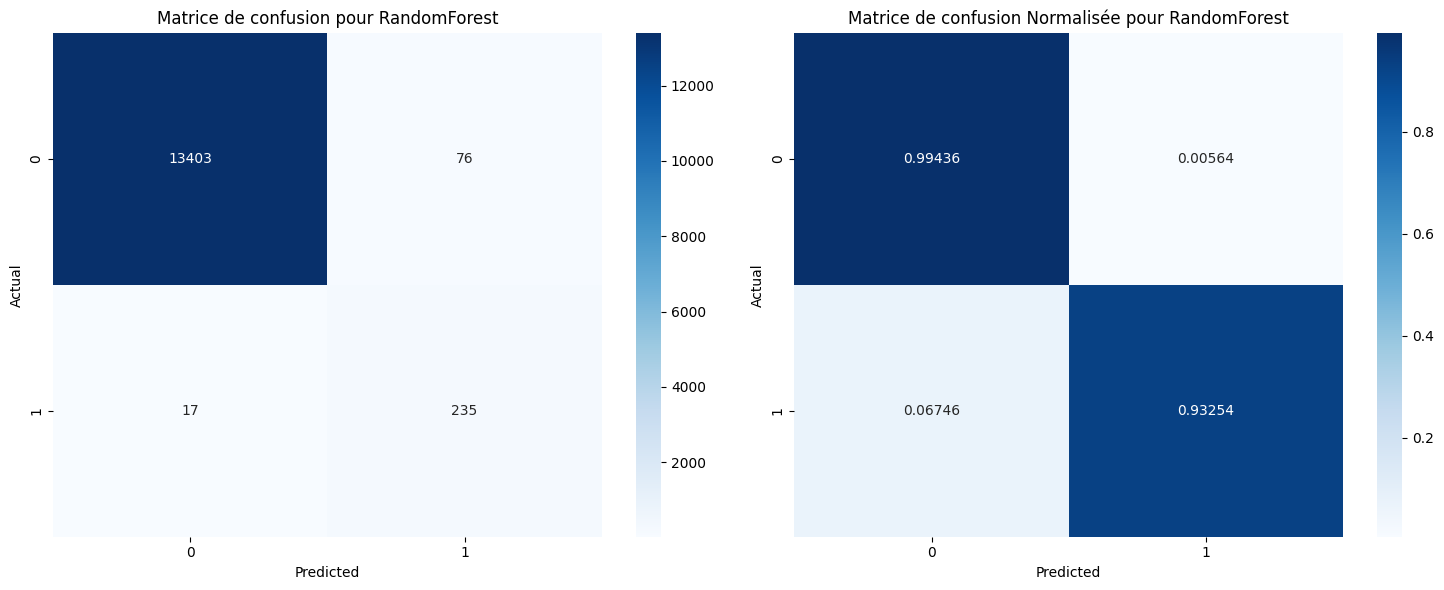

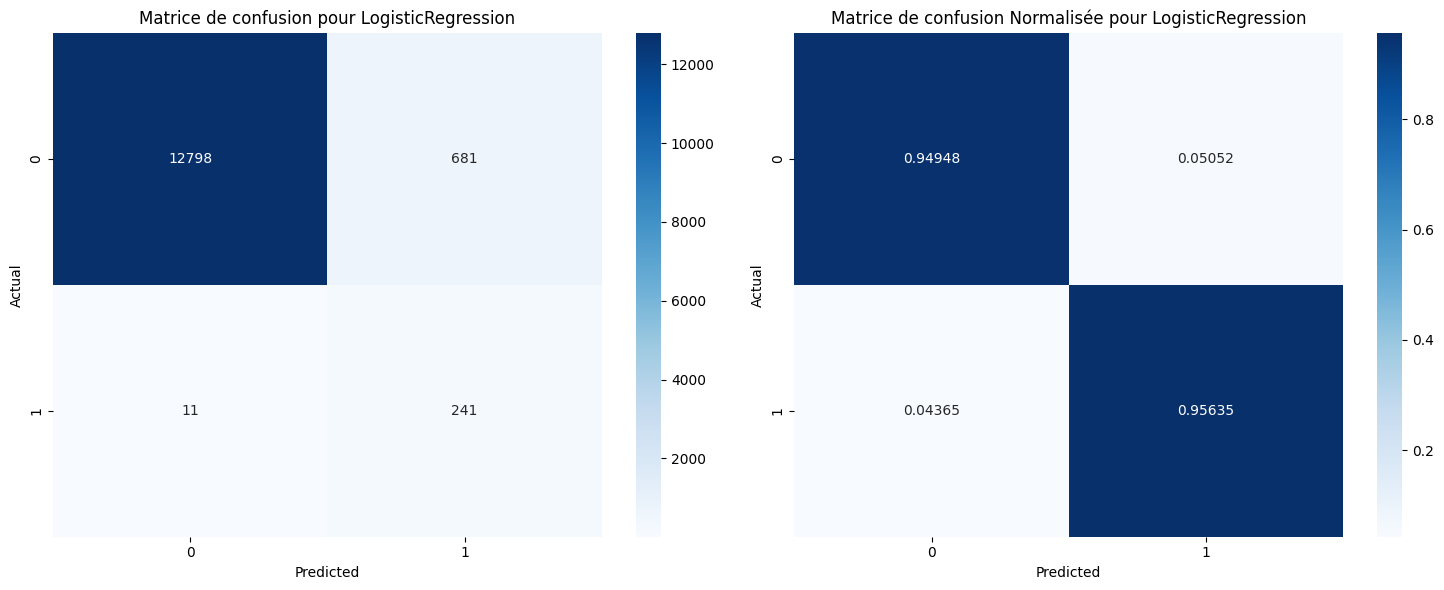

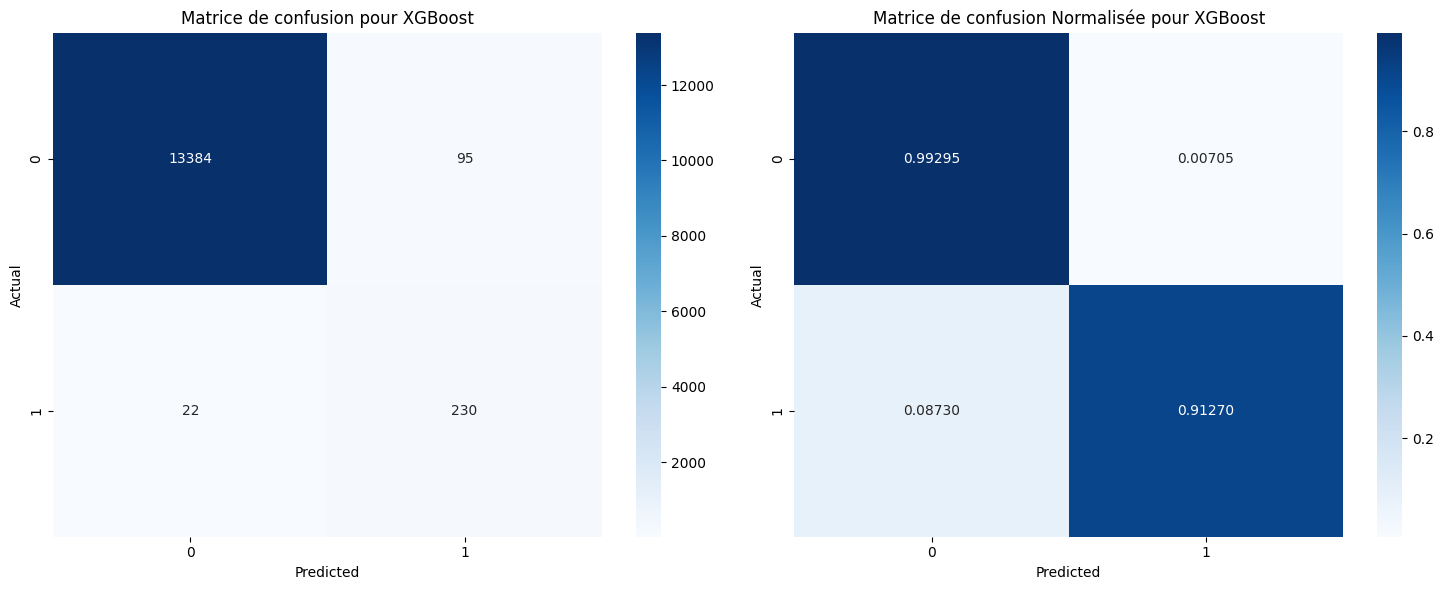

In [79]:
for name, model in models.items():
    cm = confusion_mat[name]
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de confusion pour {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm/cm.sum(axis=1, keepdims=True),fmt='.5f', annot=True, cmap='Blues')
    plt.title(f"Matrice de confusion Normalisée pour {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.tight_layout()
    plt.show()

#### Roc-Auc

Roc_Auc :
	RandomForest : 0.98776
	LogisticRegression : 0.98466
	XGBoost : 0.99131


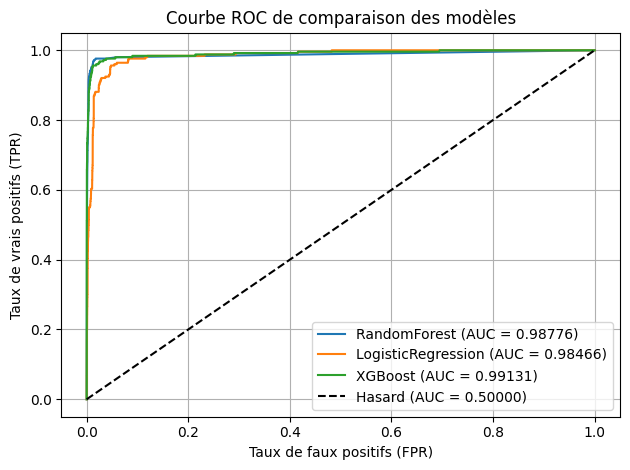

In [80]:
print(f"Roc_Auc :")
for name, model in models.items():
    fpr, tpr, _ = metrics[name]['RocCurve']
    roc_auc = auc(fpr, tpr)
    print(f"\t{name} : {roc_auc:.5f}")

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.5f})')

# Ligne diagonale "hasard"
plt.plot([0, 1], [0, 1], 'k--', label='Hasard (AUC = 0.50000)')

plt.title('Courbe ROC de comparaison des modèles')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 🔍 Résumé des performances

| Modèle                 | Accuracy |  Precision  |  Recall   | F1 Score | AUC-ROC    |
| ---------------------- | -------- | ----------- | --------- | -------- | ---------- |
| **RandomForest**       | 0.99527  | **0.88163** | **0.85714**| **0.86922**| 0.98641  |
| **LogisticRegression** | 0.98784  | 0.77070     | 0.48016   | 0.59169  | 0.97742     |
| **XGBoost**            | 0.99403  | 0.84274     | 0.82937   |  0.83600 | **0.99264** |

### ✅ Interprétation rapide :

* **RandomForest** donne le *`meilleur compromis général`* entre précision, rappel et F1.

* **XGBoost** est très proche, avec un meilleur AUC, donc un *`meilleur classement global`*.

* **LogisticRegression** est clairement *`moins performant sur le recall`*, donc *peu utile seul ici* (il rate beaucoup de défauts).

### Technique d'ensemble

**Vue les résultats précédents, essayant une technique d'ensemble (le stacking) pour espérer avoir de bien meilleurs résultats.**

In [57]:
# Pipeline pour LogisticRegression (avec normalisation)
pipe_lr = Pipeline([
    ('scaler', scaler),
    ('smote', smote2),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

# RandomForest et XGBoost n'ont pas besoin de normalisation
pipe_rf = Pipeline([
    ('smote', smote1),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipe_xgb = Pipeline([
    ('smote', smote1),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
])

# Liste des base learners avec noms + pipelines
base_learners = [
    ('rf', pipe_rf),
    ('xgb', pipe_xgb),
    ('lr', pipe_lr)
]

# Stacking classifier
stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=Pipeline([('scaler', scaler), ('smote', smote2), ('lr_f', LogisticRegression())]),
    cv=5,
    passthrough=False
)




In [62]:
# Liste des base learners avec noms + pipelines
base_learners = [
    ('rf_', Pipeline([
        #('smote', smote1),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])),

    ('xgb_', Pipeline([
        #('smote', smote1),
        ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
    ])),

    ('lr_', Pipeline([
        ('scaler', scaler),
        #('smote', smote2),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ]))
]

# Stacking classifier
stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=Pipeline([('scaler2', scaler), ('lr_f', LogisticRegression())]),
    cv=5,
    passthrough=False
)

In [63]:
name = 'StackingClassifier' 
metrics[name]={}   
reports[name], confusion_mat[name], metrics[name]['Accurancy'], metrics[name]['Precision'], metrics[name]['RecallScore'], metrics[name]['F1Score'], (fpr, tpr, _ )= train_and_evaluate(stack_clf, X_train, y_train, X_test, y_test)

roc_auc = auc(fpr, tpr)  
print(f"\tModel: {name}")
print(f"Accuracy: {metrics[name]['Accurancy']:.5f}")
print(f"Precision: {metrics[name]['Precision']:.5f}")
print(f"Recall: {metrics[name]['RecallScore']:.5f}")
print(f"F1 Score: {metrics[name]['F1Score']:.5f}")
print(f"Roc_Auc Score: {roc_auc:.5f}\n")

	Model: StackingClassifier
Accuracy: 0.99534
Precision: 0.89167
Recall: 0.84921
F1 Score: 0.86992
Roc_Auc Score: 0.99290



#### Matrices de confusion

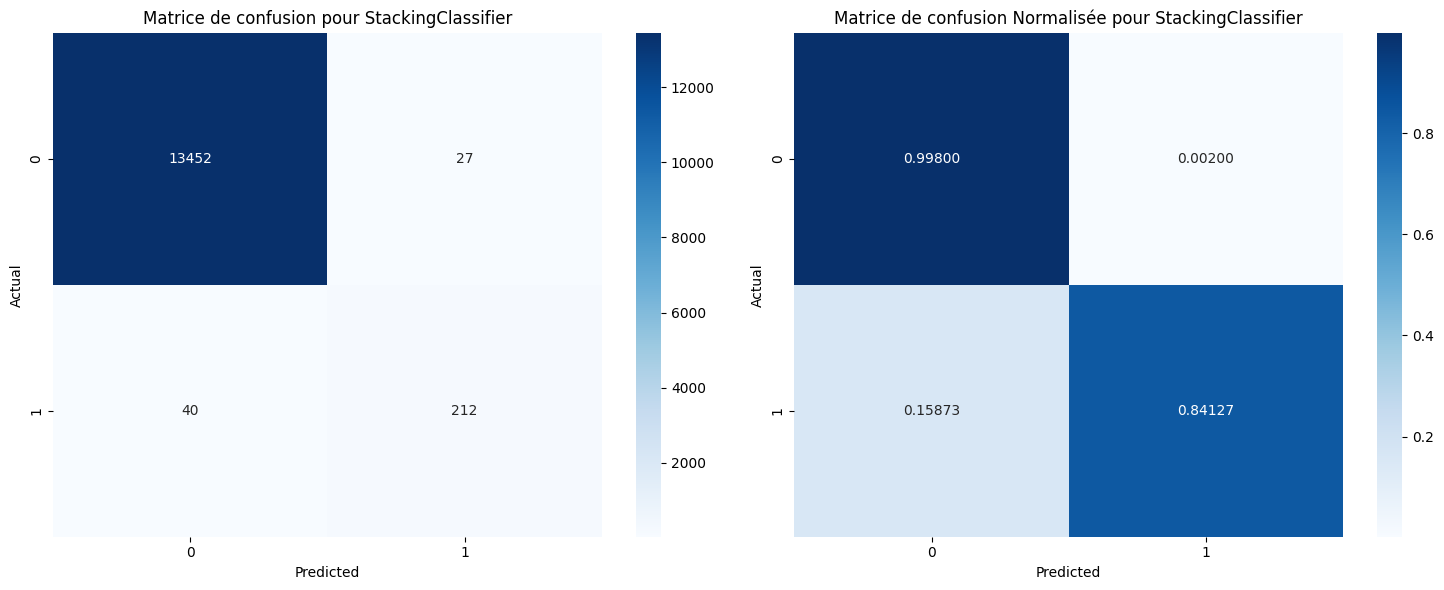

In [ ]:
cm = confusion_mat[name]
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice de confusion pour {name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm/cm.sum(axis=1, keepdims=True),fmt='.5f', annot=True, cmap='Blues')
plt.title(f"Matrice de confusion Normalisée pour {name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

### ✅ Bilan du Stacking

<u>**`Récap des preformances :`**</u> 

| Modèle                 | Accuracy |  Precision  |  Recall   | F1 Score | AUC-ROC    |
| ---------------------- | -------- | ----------- | --------- | -------- | ---------- |
| **RandomForest**       | **0.99527**  | 0.88163 | **0.85714**| **0.86922**| 0.98641     |
| **LogisticRegression** | 0.98784  | 0.77070     | 0.48016   | 0.59169  | 0.97742    |
| **XGBoost**            | 0.99403  | 0.84274     | 0.82937   |  0.83600 | 0.99264    |
|**Stacking_model**      | 0.99512  | ***0.88703*** | 0.84127 | 0.86354  | ***0.99286***|

| Métrique      | Observation                                 |
| ------------- | -------------------------------------------------------------- |
| **Accuracy**  | ✔ Très proche du meilleur (RandomForest)                       |
| **Precision** | ✅ **Meilleur (0.887)** → peu de faux positifs                  |
| **Recall**    | ⭕ Moins bon que RF (0.841 vs 0.857) → quelques faux négatifs   |
| **F1 Score**  | ⚖️ Compromis équilibré                                         |
| **AUC-ROC**   | ✅ **Meilleur (0.99286)** → très bonne séparation entre classes |


### Voyons ce que donne une cross-validation sur l'ensemble du stack

In [ ]:
print('')
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    scores = cross_val_score(stack_clf,
                             X_train,
                             y_train.values.ravel(),
                             cv=StratifiedKFold(
                                    n_splits=5,
                                    shuffle=True,
                                    random_state=42),
                             scoring=metric)
    print(f"{metric.upper()} moyen avec StackingClassifier : {np.mean(scores):.4f}")


ACCURACY moyen avec StackingClassifier : 0.9948
PRECISION moyen avec StackingClassifier : 0.8992
RECALL moyen avec StackingClassifier : 0.8052
F1 moyen avec StackingClassifier : 0.8489
ROC_AUC moyen avec StackingClassifier : 0.9935


<u>**`Récap des preformances :`**</u> 

| Modèle                 | Accuracy |  Precision  |  Recall   | F1 Score | AUC-ROC    |
| ---------------------- | -------- | ----------- | --------- | -------- | ---------- |
| **RandomForest**       | **0.99527**  | 0.88163 | **0.85714**| **0.86922**| 0.98641     |
| **LogisticRegression** | 0.98784  | 0.77070     | 0.48016   | 0.59169  | 0.97742    |
| **XGBoost**            | 0.99403  | 0.84274     | 0.82937   |  0.83600 | 0.99264    |
|**Stacking_model**      | 0.99512  | 0.88703 | 0.84127 | 0.86354  | 0.99286|
|**Stacking_model with cross-val**      | 0.9948  | ***0.8992*** | 0.8052 | 0.8489  | ***0.9935***|

### Réentrainement du model et sauvegarde de tous les éléments nécessaires

In [ ]:
# Réentrainement
stack_clf.fit(X_train, y_train)

# Sauvegarde
# Encoder
joblib.dump(Hot_encoder, "../API/processing_elements/Hot_encoder.pkl")

# Scaler
joblib.dump(scaler, "../API/processing_elements/scaler.pkl")

#Resamplers
joblib.dump(smote1, "../API/processing_elements/smote1.pkl")
joblib.dump(smote2, "../API/processing_elements/smote2.pkl")

# Feature list
joblib.dump(X_train.columns.tolist(), "../API/processing_elements/feature_list.pkl")

# Models
joblib.dump(stack_clf, "../API/models/stacking_model.pkl")
for name, model in models.items : 
    joblib.dump(model, f"../API/models/{name}.pkl")

### Voyons maintenant l'interprètabilité de notre model final : 
*“Nous allons appliqués SHAP sur le meilleur estimateur individuel (XGBoost), utilisé comme proxy interprétable du modèle de stacking.”*

In [ ]:
explainer = shap.Explainer(stack_clf.named_estimators_['xgb'])  
shap_values = explainer(X_test_scaled)

# Sauvegarde
joblib.dump(explainer, "../API/shap_explainer/explainer.pkl")

#### Summary Plot (global, top features)

In [ ]:
# Résumé global des effets
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Top features
shap.summary_plot(shap_values, X_test)  # Distribution par feature

#### Force Plot (pour une prédiction spécifique)

In [ ]:
shap.initjs() 
i = 0  # Exemple : premier individu
shap.force_plot(explainer.expected_value, shap_values[i].values, X_test.iloc[i])

#### Waterfall Plot (décision individuelle, statique)

In [ ]:
shap.plots.waterfall(shap_values[i])

#### Comparaison de plusieurs individus (local SHAP values)

In [ ]:
subset = X_test_scaled.iloc[:10]
shap_values_subset = explainer(subset)

for i in range(len(subset)):
    shap.plots.waterfall(shap_values_subset[i])

## Bulding du pipeline de processing pour l'API

In [ ]:
#from '../API/processing_elements/preprocess.py' import preprocessor

#pipeline = preprocessor(X_train)
#pipeline.fit(X_train)

# Enregistre le preprocess complet
#joblib.dump(pipeline, "../API/processing_elements/preprocess.pkl")